In [1]:
import torch
import io
import os
from math import log
import json
from botorch.models import SingleTaskGP, FixedNoiseGP
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition.multi_objective import ExpectedHypervolumeImprovement
from gpytorch.mlls import ExactMarginalLogLikelihood
import asyncio
dtype = torch.float64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def x_to_filename(x):
    return f'{x[0]}_{x[1]}_{x[2]}_{x[3]}.json'

def filename_to_x(filename):
    return [float(x) for x in filename[:-5].split('_')]

NUM_CORES=14
running_tasks={}
async def wait_for_core_to_be_available():
    while len(running_tasks)>NUM_CORES:
        await asyncio.sleep(1.0)

async def evaluate_profile(x):
    await wait_for_core_to_be_available()
    filename=x_to_filename(x)
    running_tasks[filename]=True
    #display(filename)
    existing_result_files=os.listdir("case/results")
    existing_results_x=[filename_to_x(filename) for filename in existing_result_files]
    distances=[torch.dist(torch.tensor(x),torch.tensor(existing_x)).item() for existing_x in existing_results_x]
    #display(distances)
    if len(distances)==0 or min(distances)>0.001:
        config=json.dumps({
            'p':x[0],
            'm':x[1],
            't':x[2],
            'a':x[3]
        })
        p=await asyncio.create_subprocess_shell(f'cd case; ./evaluate_airfoil.sh \'{config}\'',stdout=asyncio.subprocess.PIPE)
        await p.wait()
        #os.system(f'cd case; ./evaluate_airfoil.sh \'{config}\'')
    existing_result_files=os.listdir("case/results")
    existing_results_x=[filename_to_x(filename) for filename in existing_result_files]
    distances=[torch.dist(torch.tensor(x),torch.tensor(existing_x)).item() for existing_x in existing_results_x]
    min_distance_index=distances.index(min(distances))
    with open("case/results/"+existing_result_files[min_distance_index]) as file:
        result=json.load(file)
        if abs(result['C_L'])>100:
            return [-2.0,2.0]
        #display(result)
        running_tasks.pop(filename)
        return [result['C_L'],-result['C_D']]
await evaluate_profile([0.3,0.0,0.12,0.01])

[0.000202762, -0.0456457]

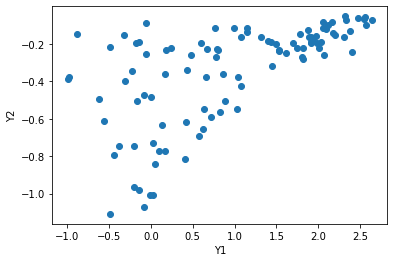

In [2]:
x_lims=[(0.1,0.9),(-0.2,0.2),(0.05,0.3),(0.01,35)]

random_initial_X=False
INITIAL_X_COUNT=100
initial_X = None
if random_initial_X or len(os.listdir("case/results_random"))<INITIAL_X_COUNT:
    initial_X = torch.rand(INITIAL_X_COUNT,4, dtype=dtype, device=device)
    for d in range(4):
        initial_X[:,d]=x_lims[d][0]+initial_X[:,d]*(x_lims[d][1]-x_lims[d][0])
else:
    # get initial X from filenames in case/results folder
    initial_X=torch.tensor([filename_to_x(filename) for filename in os.listdir("case/results_random")],dtype=dtype,device=device)
    # take six random points from the initial X
    initial_X = initial_X[torch.randperm(initial_X.shape[0])[:INITIAL_X_COUNT]]

#display(initial_X)
y=await asyncio.gather(*[evaluate_profile(x.tolist()) for x in initial_X])
train_X=initial_X
train_Y = torch.tensor(y,dtype=dtype,device=device)
import plotting
plotting.plot_population(train_Y)

In [3]:
def get_fitted_model(X,Y):
    train_Yvar = torch.full_like(Y, 0.01)
    gp= FixedNoiseGP(X, Y, train_Yvar)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)
    return gp

In [4]:
#from botorch.utils.multi_objective.scalarization import get_chebyshev_scalarization
from botorch.acquisition.objective import GenericMCObjective
from botorch.acquisition import ExpectedImprovement
from botorch.utils.sampling import sample_simplex
from torch import Tensor
from botorch.optim import optimize_acqf
from botorch.utils.transforms import normalize

weights=sample_simplex(2,6)
#weights=torch.tensor([[1,0],[0,1]],dtype=dtype)
NUM_WEIGHTS=weights.shape[0]
bounds = torch.stack([torch.tensor(x_lims)[:,0], torch.tensor(x_lims)[:,1]])
print("weights=",weights)

def get_chebyshev_scalarization(
    weights: Tensor, Y: Tensor, alpha: float = 0.05
):
    def chebyshev_obj(Y: Tensor) -> Tensor:
        product = weights * Y
        return product.min(dim=-1).values + alpha * product.sum(dim=-1)
    Y_bounds = torch.stack([Y.min(dim=-2).values, Y.max(dim=-2).values])
    def obj(Y: Tensor) -> Tensor:
        # scale to [0,1]
        Y_normalized = normalize(Y, bounds=Y_bounds)-1
        return chebyshev_obj(Y=Y_normalized)

    return obj

import pandas as pd
expected_improvements=[[] for _ in range(NUM_WEIGHTS)]
actual_improvements=[[] for _ in range(NUM_WEIGHTS)]
scalarized_values=[[] for _ in range(NUM_WEIGHTS)]
variances=[[] for _ in range(NUM_WEIGHTS)]
NUM_ITERATIONS=5
for iteration in range(NUM_ITERATIONS):
    evaluation_promises=[]
    new_X=[]
    scalarizations=[]
    for i in range(NUM_WEIGHTS):
        scalarization=get_chebyshev_scalarization(weights[i,:],train_Y,alpha=0)
        scalarizations.append(scalarization)
        acquisition_values=scalarization(train_Y)
        display(acquisition_values)
        model=get_fitted_model(train_X,acquisition_values.unsqueeze(1))
        prediction=model.posterior(torch.tensor([[0.4,0.0,0.15,0.0]]))
        print(prediction.mean)
        acquisition_function=ExpectedImprovement(model,acquisition_values.max())
        candidate, acq_value = optimize_acqf(
            acquisition_function, bounds=bounds, q=1, num_restarts=1, batch_initial_conditions=train_X
        )
        expected_improvements[i].append(acq_value.tolist())
        expected_value=model.posterior(candidate.unsqueeze(0))
        print("new candidate=",candidate," with expected improvement",acq_value.tolist()," and expected value of ",expected_value.mean,"+-",torch.sqrt(expected_value.variance).tolist())
        new_X.append(candidate)
        variances.append(expected_value.variance.tolist())
        evaluation_promises.append(evaluate_profile(candidate.tolist()))
    #print("promises: ",evaluation_promises)
    results=await asyncio.gather(*evaluation_promises)
    print("objective results=",results)
    for i in range(NUM_WEIGHTS):
        actual_value=scalarizations[i](torch.tensor(results[i]))
        print("actual value=",actual_value)
        acquisition_values=scalarization(train_Y)
        actual_improvement=actual_value-acquisition_values.max()
        print("actual improvement=",actual_improvement)
        actual_improvements[i].append(actual_improvement.tolist())
        scalarized_values[i].append(actual_value.tolist())
    train_X = torch.cat([train_X, torch.stack(new_X)])
    train_Y = torch.cat([train_Y, torch.tensor(results)])

df=pd.DataFrame({
    'objective values':scalarized_values,
    'expected improvements': expected_improvements,
    'actual improvements':actual_improvements
})
df

weights= tensor([[0.6231, 0.3769],
        [0.1338, 0.8662],
        [0.2981, 0.7019],
        [0.8130, 0.1870],
        [0.7857, 0.2143],
        [0.7942, 0.2058]])


tensor([-0.1254, -0.1440, -0.3790, -0.4449, -0.6195, -0.4625, -0.3206, -0.4238,
        -0.2280, -0.3194, -0.5587, -0.4626, -0.0672, -0.0814, -0.5285, -0.3697,
        -0.1149, -0.0147, -0.1898, -0.2565, -0.4537, -0.1081, -0.4924, -0.3408,
        -0.2763, -0.4366, -0.1411, -0.3369, -0.1404, -0.2688, -0.4771, -0.1974,
        -0.3444, -0.2836, -0.5063, -0.1293, -0.3121, -0.4676, -0.1011, -0.4475,
        -0.4524, -0.3055, -0.3008, -0.0559, -0.2568, -0.1123, -0.1050, -0.4826,
        -0.4863, -0.6231, -0.3151, -0.5189, -0.3549, -0.5355, -0.2133, -0.4814,
        -0.0990, -0.3301, -0.0570, -0.4483, -0.5079, -0.4666, -0.4872, -0.1768,
        -0.0806, -0.2064, -0.0999, -0.3506, -0.1908, -0.1622, -0.0946, -0.1477,
        -0.3818, -0.3829, -0.4241, -0.0523, -0.0289, -0.1544, -0.0765, -0.2040,
        -0.2684, -0.3456, -0.1199, -0.0895, -0.4767, -0.1257, -0.1244, -0.3166,
        -0.4293, -0.0157, -0.2735, -0.5369, -0.6047, -0.4209, -0.0168, -0.0077,
        -0.4121, -0.5496, -0.1309, -0.04

tensor([[-0.3923]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>)
new candidate= tensor([ 0.7938,  0.2000,  0.1330, 19.9163], dtype=torch.float64)  with expected improvement 0.008460668062768536  and expected value of  tensor([[-0.0624]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>) +- [[0.06917649105482358]]


tensor([-0.0904, -0.1768, -0.2359, -0.6491, -0.2659, -0.1634, -0.0689, -0.5916,
        -0.0896, -0.1786, -0.3607, -0.0993, -0.1545, -0.0255, -0.6065, -0.1677,
        -0.0855, -0.0032, -0.1538, -0.0551, -0.7834, -0.1396, -0.2396, -0.2669,
        -0.4063, -0.5903, -0.1875, -0.1428, -0.1378, -0.0894, -0.7636, -0.1228,
        -0.4066, -0.0609, -0.2818, -0.0894, -0.4187, -0.3430, -0.0520, -0.7823,
        -0.3535, -0.2548, -0.3735, -0.0120, -0.0682, -0.1181, -0.1129, -0.1184,
        -0.5671, -0.2741, -0.1491, -0.5688, -0.5261, -0.8662, -0.1075, -0.3707,
        -0.1715, -0.4423, -0.0924, -0.5551, -0.1091, -0.8364, -0.7498, -0.1606,
        -0.0731, -0.1112, -0.0245, -0.1170, -0.1496, -0.1189, -0.0561, -0.0796,
        -0.4620, -0.6251, -0.2518, -0.0153, -0.0079, -0.1406, -0.0843, -0.2176,
        -0.3055, -0.4960, -0.0977, -0.0395, -0.1138, -0.1161, -0.1124, -0.1430,
        -0.4769, -0.0127, -0.2649, -0.1344, -0.1298, -0.1495, -0.0386, -0.0177,
        -0.1377, -0.4587, -0.0620, -0.06

tensor([[-0.1410]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>)
new candidate= tensor([ 0.8690,  0.1792,  0.3000, 23.3488], dtype=torch.float64)  with expected improvement 0.015060063199863841  and expected value of  tensor([[-0.0606]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>) +- [[0.09240507333700805]]


tensor([-0.0732, -0.1433, -0.1912, -0.5259, -0.2964, -0.2213, -0.1534, -0.4794,
        -0.1091, -0.1528, -0.2923, -0.2213, -0.1252, -0.0390, -0.4915, -0.1769,
        -0.0693, -0.0071, -0.1247, -0.1228, -0.6348, -0.1131, -0.2356, -0.2163,
        -0.3292, -0.4783, -0.1519, -0.1612, -0.1116, -0.1286, -0.6187, -0.0995,
        -0.3295, -0.1357, -0.2422, -0.0724, -0.3392, -0.2779, -0.0484, -0.6339,
        -0.2865, -0.2065, -0.3026, -0.0267, -0.1229, -0.0957, -0.0915, -0.2309,
        -0.4595, -0.2981, -0.1508, -0.4609, -0.4263, -0.7019, -0.1020, -0.3004,
        -0.1390, -0.3584, -0.0749, -0.4498, -0.2430, -0.6777, -0.6076, -0.1301,
        -0.0593, -0.0987, -0.0478, -0.1677, -0.1212, -0.0963, -0.0454, -0.0707,
        -0.3743, -0.5065, -0.2041, -0.0250, -0.0138, -0.1139, -0.0683, -0.1763,
        -0.2475, -0.4019, -0.0791, -0.0428, -0.2281, -0.0940, -0.0911, -0.1515,
        -0.3864, -0.0103, -0.2147, -0.2569, -0.2893, -0.2014, -0.0313, -0.0143,
        -0.1972, -0.3717, -0.0626, -0.05

tensor([[-0.2124]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>)
new candidate= tensor([ 0.8846,  0.1632,  0.1120, 19.7402], dtype=torch.float64)  with expected improvement 0.011730287213705035  and expected value of  tensor([[-0.0479]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>) +- [[0.06880406765177716]]


tensor([-0.1636, -0.1879, -0.4945, -0.5805, -0.8084, -0.6036, -0.4184, -0.5530,
        -0.2975, -0.4168, -0.7290, -0.6036, -0.0541, -0.1063, -0.6896, -0.4825,
        -0.1499, -0.0192, -0.2477, -0.3348, -0.5920, -0.1410, -0.6425, -0.4447,
        -0.3605, -0.5697, -0.1842, -0.4397, -0.1832, -0.3508, -0.6226, -0.2576,
        -0.4494, -0.3700, -0.6606, -0.1687, -0.4072, -0.6101, -0.1319, -0.5840,
        -0.5903, -0.3986, -0.3925, -0.0729, -0.3351, -0.1465, -0.1370, -0.6297,
        -0.6345, -0.8130, -0.4112, -0.6771, -0.4631, -0.6988, -0.2783, -0.6281,
        -0.1292, -0.4307, -0.0744, -0.5850, -0.6627, -0.6088, -0.6357, -0.2308,
        -0.1051, -0.2693, -0.1304, -0.4575, -0.2490, -0.2116, -0.1234, -0.1927,
        -0.4982, -0.4997, -0.5534, -0.0683, -0.0377, -0.2015, -0.0999, -0.2663,
        -0.3502, -0.4509, -0.1565, -0.1168, -0.6220, -0.1640, -0.1623, -0.4132,
        -0.5602, -0.0204, -0.3568, -0.7006, -0.7890, -0.5492, -0.0167, -0.0038,
        -0.5378, -0.7171, -0.1708, -0.05

tensor([[-0.5283]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>)
new candidate= tensor([ 0.7932,  0.2000,  0.1530, 23.5940], dtype=torch.float64)  with expected improvement 0.010702716998562118  and expected value of  tensor([[-0.0675]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>) +- [[0.0834397835232907]]


tensor([-0.1581, -0.1816, -0.4779, -0.5610, -0.7813, -0.5833, -0.4043, -0.5345,
        -0.2875, -0.4028, -0.7045, -0.5833, -0.0523, -0.1027, -0.6664, -0.4662,
        -0.1449, -0.0186, -0.2393, -0.3235, -0.5721, -0.1363, -0.6209, -0.4297,
        -0.3484, -0.5506, -0.1780, -0.4249, -0.1770, -0.3390, -0.6016, -0.2489,
        -0.4343, -0.3576, -0.6384, -0.1630, -0.3935, -0.5896, -0.1275, -0.5643,
        -0.5705, -0.3852, -0.3793, -0.0705, -0.3238, -0.1416, -0.1324, -0.6085,
        -0.6132, -0.7857, -0.3973, -0.6543, -0.4475, -0.6753, -0.2689, -0.6070,
        -0.1249, -0.4163, -0.0719, -0.5654, -0.6405, -0.5884, -0.6144, -0.2230,
        -0.1016, -0.2602, -0.1260, -0.4421, -0.2407, -0.2045, -0.1193, -0.1862,
        -0.4814, -0.4829, -0.5348, -0.0660, -0.0364, -0.1947, -0.0965, -0.2573,
        -0.3384, -0.4358, -0.1512, -0.1129, -0.6011, -0.1585, -0.1569, -0.3993,
        -0.5413, -0.0197, -0.3448, -0.6771, -0.7625, -0.5307, -0.0162, -0.0044,
        -0.5197, -0.6930, -0.1650, -0.05

tensor([[-0.5087]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>)
new candidate= tensor([ 0.7838,  0.2000,  0.1524, 23.6376], dtype=torch.float64)  with expected improvement 0.01042507717858326  and expected value of  tensor([[-0.0673]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>) +- [[0.081947774991236]]


tensor([-0.1598, -0.1836, -0.4831, -0.5670, -0.7897, -0.5896, -0.4087, -0.5403,
        -0.2906, -0.4072, -0.7122, -0.5897, -0.0529, -0.1038, -0.6736, -0.4713,
        -0.1465, -0.0188, -0.2419, -0.3270, -0.5783, -0.1378, -0.6276, -0.4344,
        -0.3521, -0.5566, -0.1799, -0.4295, -0.1789, -0.3427, -0.6082, -0.2516,
        -0.4390, -0.3615, -0.6453, -0.1648, -0.3978, -0.5960, -0.1289, -0.5705,
        -0.5767, -0.3894, -0.3834, -0.0712, -0.3273, -0.1432, -0.1338, -0.6151,
        -0.6198, -0.7942, -0.4016, -0.6614, -0.4524, -0.6826, -0.2719, -0.6136,
        -0.1262, -0.4208, -0.0727, -0.5715, -0.6474, -0.5948, -0.6210, -0.2254,
        -0.1027, -0.2631, -0.1274, -0.4469, -0.2433, -0.2067, -0.1205, -0.1882,
        -0.4866, -0.4881, -0.5406, -0.0667, -0.0368, -0.1968, -0.0976, -0.2601,
        -0.3421, -0.4405, -0.1528, -0.1141, -0.6076, -0.1602, -0.1586, -0.4036,
        -0.5472, -0.0200, -0.3486, -0.6844, -0.7708, -0.5365, -0.0163, -0.0042,
        -0.5253, -0.7005, -0.1668, -0.05

tensor([[-0.5148]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>)
new candidate= tensor([ 0.7868,  0.2000,  0.1526, 23.6240], dtype=torch.float64)  with expected improvement 0.010512100239645387  and expected value of  tensor([[-0.0673]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>) +- [[0.08241469376504847]]


objective results= [[2.46906, -0.11511], [2.64462, -0.0409219], [2.39698, -0.120333], [2.60231, -0.061409], [2.63166, -0.0582962], [2.51895, -0.0450821]]
actual value= tensor(-0.0298, dtype=torch.float64)
actual improvement= tensor(-0.0256, dtype=torch.float64)
actual value= tensor(5.8083e-05, dtype=torch.float64)
actual improvement= tensor(0.0043, dtype=torch.float64)
actual value= tensor(-0.0448, dtype=torch.float64)
actual improvement= tensor(-0.0406, dtype=torch.float64)
actual value= tensor(-0.0091, dtype=torch.float64)
actual improvement= tensor(-0.0049, dtype=torch.float64)
actual value= tensor(-0.0025, dtype=torch.float64)
actual improvement= tensor(0.0017, dtype=torch.float64)
actual value= tensor(-0.0271, dtype=torch.float64)
actual improvement= tensor(-0.0229, dtype=torch.float64)


tensor([-0.1256, -0.1442, -0.3791, -0.4449, -0.6195, -0.4626, -0.3208, -0.4239,
        -0.2282, -0.3196, -0.5587, -0.4627, -0.0707, -0.0817, -0.5285, -0.3698,
        -0.1151, -0.0150, -0.1900, -0.2567, -0.4537, -0.1083, -0.4924, -0.3409,
        -0.2764, -0.4367, -0.1414, -0.3371, -0.1406, -0.2690, -0.4772, -0.1976,
        -0.3445, -0.2837, -0.5063, -0.1295, -0.3122, -0.4676, -0.1013, -0.4476,
        -0.4525, -0.3056, -0.3010, -0.0561, -0.2570, -0.1125, -0.1052, -0.4826,
        -0.4863, -0.6231, -0.3152, -0.5189, -0.3550, -0.5356, -0.2135, -0.4814,
        -0.0992, -0.3302, -0.0573, -0.4484, -0.5079, -0.4667, -0.4872, -0.1770,
        -0.0808, -0.2065, -0.1001, -0.3507, -0.1910, -0.1624, -0.0948, -0.1479,
        -0.3819, -0.3830, -0.4242, -0.0526, -0.0291, -0.1546, -0.0768, -0.2042,
        -0.2685, -0.3457, -0.1201, -0.0898, -0.4768, -0.1259, -0.1246, -0.3168,
        -0.4294, -0.0159, -0.2736, -0.5370, -0.6047, -0.4210, -0.0209, -0.0119,
        -0.4122, -0.5496, -0.1311, -0.04

tensor([[-0.3931]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>)
new candidate= tensor([ 0.7503,  0.2000,  0.3000, 22.0683], dtype=torch.float64)  with expected improvement 0.009088071671658537  and expected value of  tensor([[-0.0326]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>) +- [[0.054112725935600514]]


tensor([-0.0991, -0.1846, -0.2430, -0.6515, -0.2727, -0.1713, -0.0689, -0.5947,
        -0.0983, -0.1864, -0.3664, -0.0993, -0.1625, -0.0350, -0.6094, -0.1755,
        -0.0943, -0.0109, -0.1619, -0.0602, -0.7843, -0.1478, -0.2467, -0.2736,
        -0.4115, -0.5934, -0.1951, -0.1509, -0.1459, -0.0982, -0.7647, -0.1312,
        -0.4117, -0.0609, -0.2884, -0.0981, -0.4237, -0.3489, -0.0611, -0.7832,
        -0.3593, -0.2617, -0.3790, -0.0121, -0.0772, -0.1265, -0.1213, -0.1268,
        -0.5705, -0.2808, -0.1572, -0.5721, -0.5300, -0.8662, -0.1160, -0.3763,
        -0.1793, -0.4470, -0.1011, -0.5586, -0.1091, -0.8367, -0.7511, -0.1685,
        -0.0820, -0.1197, -0.0340, -0.1254, -0.1576, -0.1273, -0.0652, -0.0884,
        -0.4665, -0.6278, -0.2587, -0.0248, -0.0176, -0.1487, -0.0931, -0.2249,
        -0.3118, -0.5001, -0.1063, -0.0488, -0.1223, -0.1245, -0.1209, -0.1511,
        -0.4812, -0.0222, -0.2717, -0.1427, -0.1299, -0.1576, -0.0479, -0.0272,
        -0.1459, -0.4633, -0.0710, -0.07

tensor([[-0.1443]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>)
new candidate= tensor([ 0.7082,  0.1684,  0.3000, 24.8019], dtype=torch.float64)  with expected improvement 0.013503145528086548  and expected value of  tensor([[-0.0255]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>) +- [[0.06053004077284935]]


tensor([-0.0803, -0.1496, -0.1969, -0.5279, -0.2964, -0.2213, -0.1535, -0.4819,
        -0.1092, -0.1529, -0.2969, -0.2214, -0.1317, -0.0391, -0.4938, -0.1770,
        -0.0764, -0.0088, -0.1311, -0.1228, -0.6355, -0.1197, -0.2356, -0.2217,
        -0.3334, -0.4808, -0.1581, -0.1613, -0.1183, -0.1287, -0.6197, -0.1063,
        -0.3336, -0.1358, -0.2423, -0.0795, -0.3433, -0.2827, -0.0495, -0.6346,
        -0.2911, -0.2121, -0.3071, -0.0269, -0.1230, -0.1025, -0.0983, -0.2309,
        -0.4623, -0.2981, -0.1508, -0.4636, -0.4294, -0.7019, -0.1021, -0.3049,
        -0.1453, -0.3622, -0.0819, -0.4526, -0.2430, -0.6780, -0.6087, -0.1365,
        -0.0665, -0.0988, -0.0479, -0.1678, -0.1277, -0.1031, -0.0528, -0.0716,
        -0.3780, -0.5087, -0.2097, -0.0252, -0.0142, -0.1205, -0.0755, -0.1822,
        -0.2526, -0.4052, -0.0861, -0.0430, -0.2281, -0.1009, -0.0979, -0.1516,
        -0.3899, -0.0180, -0.2201, -0.2569, -0.2893, -0.2014, -0.0388, -0.0221,
        -0.1972, -0.3754, -0.0627, -0.05

tensor([[-0.2127]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>)
new candidate= tensor([ 0.6643,  0.1728,  0.3000, 25.0197], dtype=torch.float64)  with expected improvement 0.010693667890363714  and expected value of  tensor([[-0.0301]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>) +- [[0.056712201440949225]]


tensor([-0.1639, -0.1882, -0.4946, -0.5806, -0.8084, -0.6036, -0.4186, -0.5532,
        -0.2977, -0.4170, -0.7291, -0.6037, -0.0545, -0.1066, -0.6896, -0.4826,
        -0.1502, -0.0196, -0.2479, -0.3350, -0.5921, -0.1413, -0.6425, -0.4448,
        -0.3607, -0.5698, -0.1845, -0.4398, -0.1834, -0.3510, -0.6226, -0.2578,
        -0.4495, -0.3702, -0.6607, -0.1689, -0.4074, -0.6102, -0.1322, -0.5841,
        -0.5904, -0.3988, -0.3927, -0.0732, -0.3353, -0.1468, -0.1373, -0.6298,
        -0.6346, -0.8130, -0.4113, -0.6771, -0.4632, -0.6988, -0.2785, -0.6282,
        -0.1295, -0.4309, -0.0747, -0.5851, -0.6628, -0.6089, -0.6358, -0.2310,
        -0.1054, -0.2695, -0.1307, -0.4576, -0.2493, -0.2119, -0.1237, -0.1930,
        -0.4983, -0.4998, -0.5535, -0.0686, -0.0380, -0.2017, -0.1002, -0.2665,
        -0.3504, -0.4511, -0.1568, -0.1171, -0.6221, -0.1642, -0.1626, -0.4133,
        -0.5603, -0.0208, -0.3570, -0.7007, -0.7891, -0.5493, -0.0171, -0.0059,
        -0.5379, -0.7172, -0.1710, -0.05

tensor([[-0.5290]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>)
new candidate= tensor([ 0.7606,  0.2000,  0.3000, 22.0717], dtype=torch.float64)  with expected improvement 0.01103168050078431  and expected value of  tensor([[-0.0305]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>) +- [[0.058078043373713126]]


tensor([-0.1583, -0.1819, -0.4780, -0.5611, -0.7813, -0.5834, -0.4045, -0.5346,
        -0.2877, -0.4030, -0.7046, -0.5834, -0.0526, -0.1030, -0.6664, -0.4664,
        -0.1452, -0.0189, -0.2396, -0.3237, -0.5722, -0.1366, -0.6209, -0.4299,
        -0.3486, -0.5507, -0.1783, -0.4251, -0.1773, -0.3392, -0.6017, -0.2492,
        -0.4344, -0.3578, -0.6385, -0.1633, -0.3937, -0.5897, -0.1278, -0.5644,
        -0.5706, -0.3854, -0.3795, -0.0708, -0.3240, -0.1419, -0.1327, -0.6086,
        -0.6133, -0.7857, -0.3975, -0.6544, -0.4477, -0.6754, -0.2692, -0.6071,
        -0.1251, -0.4164, -0.0722, -0.5654, -0.6405, -0.5885, -0.6144, -0.2232,
        -0.1019, -0.2605, -0.1263, -0.4422, -0.2409, -0.2048, -0.1195, -0.1865,
        -0.4815, -0.4830, -0.5349, -0.0663, -0.0367, -0.1950, -0.0968, -0.2575,
        -0.3386, -0.4359, -0.1515, -0.1132, -0.6012, -0.1587, -0.1572, -0.3994,
        -0.5414, -0.0201, -0.3450, -0.6771, -0.7625, -0.5309, -0.0165, -0.0067,
        -0.5198, -0.6931, -0.1653, -0.05

tensor([[-0.5095]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>)
new candidate= tensor([ 0.7582,  0.2000,  0.3000, 22.0671], dtype=torch.float64)  with expected improvement 0.010813442522512075  and expected value of  tensor([[-0.0306]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>) +- [[0.05752676017138966]]


tensor([-0.1601, -0.1839, -0.4832, -0.5671, -0.7897, -0.5897, -0.4089, -0.5404,
        -0.2909, -0.4073, -0.7122, -0.5897, -0.0532, -0.1041, -0.6737, -0.4714,
        -0.1467, -0.0191, -0.2422, -0.3272, -0.5784, -0.1381, -0.6277, -0.4345,
        -0.3523, -0.5567, -0.1802, -0.4297, -0.1792, -0.3429, -0.6082, -0.2519,
        -0.4391, -0.3617, -0.6454, -0.1650, -0.3980, -0.5961, -0.1292, -0.5706,
        -0.5768, -0.3896, -0.3836, -0.0715, -0.3275, -0.1434, -0.1341, -0.6152,
        -0.6199, -0.7942, -0.4018, -0.6615, -0.4525, -0.6827, -0.2721, -0.6137,
        -0.1265, -0.4209, -0.0730, -0.5716, -0.6475, -0.5948, -0.6211, -0.2257,
        -0.1030, -0.2633, -0.1277, -0.4470, -0.2435, -0.2070, -0.1208, -0.1885,
        -0.4868, -0.4882, -0.5407, -0.0670, -0.0371, -0.1971, -0.0979, -0.2603,
        -0.3423, -0.4407, -0.1531, -0.1144, -0.6077, -0.1605, -0.1589, -0.4038,
        -0.5473, -0.0203, -0.3488, -0.6844, -0.7708, -0.5366, -0.0167, -0.0065,
        -0.5255, -0.7006, -0.1671, -0.05

tensor([[-0.5156]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>)
new candidate= tensor([ 0.7590,  0.2000,  0.3000, 22.0685], dtype=torch.float64)  with expected improvement 0.010882298738215439  and expected value of  tensor([[-0.0306]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>) +- [[0.05769907019141742]]


objective results= [[2.54231, -0.0728878], [2.54365, -0.0363276], [2.53892, -0.0300713], [2.59021, -0.0674745], [0.66566, -0.157429], [2.54293, -0.0675877]]
actual value= tensor(-0.0175, dtype=torch.float64)
actual improvement= tensor(-0.0175, dtype=torch.float64)
actual value= tensor(-0.0037, dtype=torch.float64)
actual improvement= tensor(-0.0037, dtype=torch.float64)
actual value= tensor(-0.0087, dtype=torch.float64)
actual improvement= tensor(-0.0087, dtype=torch.float64)
actual value= tensor(-0.0121, dtype=torch.float64)
actual improvement= tensor(-0.0121, dtype=torch.float64)
actual value= tensor(-0.4271, dtype=torch.float64)
actual improvement= tensor(-0.4271, dtype=torch.float64)
actual value= tensor(-0.0222, dtype=torch.float64)
actual improvement= tensor(-0.0222, dtype=torch.float64)


tensor([-0.1256, -0.1442, -0.3791, -0.4449, -0.6195, -0.4626, -0.3208, -0.4239,
        -0.2282, -0.3196, -0.5587, -0.4627, -0.0738, -0.0817, -0.5285, -0.3698,
        -0.1151, -0.0150, -0.1900, -0.2567, -0.4537, -0.1083, -0.4924, -0.3409,
        -0.2764, -0.4367, -0.1414, -0.3371, -0.1406, -0.2690, -0.4772, -0.1976,
        -0.3445, -0.2837, -0.5063, -0.1295, -0.3122, -0.4676, -0.1013, -0.4476,
        -0.4525, -0.3056, -0.3010, -0.0561, -0.2570, -0.1125, -0.1052, -0.4826,
        -0.4863, -0.6231, -0.3152, -0.5189, -0.3550, -0.5356, -0.2135, -0.4814,
        -0.0992, -0.3302, -0.0573, -0.4484, -0.5079, -0.4667, -0.4872, -0.1770,
        -0.0808, -0.2065, -0.1001, -0.3507, -0.1910, -0.1624, -0.0948, -0.1479,
        -0.3819, -0.3830, -0.4242, -0.0526, -0.0291, -0.1546, -0.0768, -0.2042,
        -0.2685, -0.3457, -0.1201, -0.0898, -0.4768, -0.1259, -0.1246, -0.3168,
        -0.4294, -0.0159, -0.2736, -0.5370, -0.6047, -0.4210, -0.0244, -0.0155,
        -0.4122, -0.5496, -0.1311, -0.04

tensor([[-0.3930]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>)
new candidate= tensor([ 0.6053,  0.2000,  0.0744, 25.4045], dtype=torch.float64)  with expected improvement 0.009889962082462293  and expected value of  tensor([[-0.0365]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>) +- [[0.05655263117015427]]


tensor([-0.1068, -0.1914, -0.2493, -0.6537, -0.2787, -0.1783, -0.0689, -0.5974,
        -0.1061, -0.1932, -0.3714, -0.0993, -0.1696, -0.0434, -0.6120, -0.1825,
        -0.1020, -0.0195, -0.1689, -0.0683, -0.7851, -0.1550, -0.2529, -0.2796,
        -0.4161, -0.5962, -0.2019, -0.1581, -0.1532, -0.1059, -0.7658, -0.1386,
        -0.4163, -0.0667, -0.2942, -0.1059, -0.4281, -0.3541, -0.0692, -0.7841,
        -0.3644, -0.2678, -0.3839, -0.0184, -0.0851, -0.1339, -0.1288, -0.1343,
        -0.5734, -0.2867, -0.1643, -0.5751, -0.5333, -0.8662, -0.1235, -0.3812,
        -0.1862, -0.4513, -0.1088, -0.5617, -0.1091, -0.8370, -0.7523, -0.1755,
        -0.0899, -0.1272, -0.0424, -0.1328, -0.1647, -0.1347, -0.0733, -0.0962,
        -0.4705, -0.6302, -0.2648, -0.0333, -0.0261, -0.1559, -0.1009, -0.2313,
        -0.3174, -0.5038, -0.1139, -0.0570, -0.1298, -0.1320, -0.1284, -0.1583,
        -0.4851, -0.0307, -0.2776, -0.1500, -0.1299, -0.1647, -0.0561, -0.0357,
        -0.1532, -0.4674, -0.0790, -0.08

tensor([[-0.1479]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>)
new candidate= tensor([ 0.9000,  0.1983,  0.3000, 25.1721], dtype=torch.float64)  with expected improvement 0.010433095160538483  and expected value of  tensor([[-0.0371]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>) +- [[0.05857850356078085]]


tensor([-0.0865, -0.1551, -0.2020, -0.5297, -0.2964, -0.2213, -0.1535, -0.4841,
        -0.1092, -0.1565, -0.3009, -0.2214, -0.1374, -0.0391, -0.4959, -0.1770,
        -0.0827, -0.0158, -0.1369, -0.1228, -0.6362, -0.1256, -0.2356, -0.2265,
        -0.3371, -0.4831, -0.1636, -0.1613, -0.1241, -0.1287, -0.6205, -0.1123,
        -0.3373, -0.1358, -0.2423, -0.0858, -0.3469, -0.2869, -0.0561, -0.6353,
        -0.2953, -0.2170, -0.3111, -0.0269, -0.1230, -0.1085, -0.1044, -0.2309,
        -0.4647, -0.2981, -0.1508, -0.4660, -0.4322, -0.7019, -0.1021, -0.3089,
        -0.1509, -0.3657, -0.0882, -0.4551, -0.2430, -0.6782, -0.6096, -0.1422,
        -0.0729, -0.1031, -0.0479, -0.1678, -0.1335, -0.1091, -0.0594, -0.0780,
        -0.3813, -0.5106, -0.2146, -0.0270, -0.0212, -0.1264, -0.0818, -0.1874,
        -0.2572, -0.4082, -0.0923, -0.0462, -0.2281, -0.1069, -0.1040, -0.1516,
        -0.3931, -0.0249, -0.2250, -0.2569, -0.2893, -0.2014, -0.0455, -0.0289,
        -0.1972, -0.3787, -0.0640, -0.06

tensor([[-0.2138]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>)
new candidate= tensor([ 0.5123,  0.1763,  0.3000, 25.4439], dtype=torch.float64)  with expected improvement 0.009765023829009341  and expected value of  tensor([[-0.0302]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>) +- [[0.047970525556853855]]


tensor([-0.1639, -0.1882, -0.4946, -0.5806, -0.8084, -0.6036, -0.4186, -0.5532,
        -0.2977, -0.4170, -0.7291, -0.6037, -0.0545, -0.1066, -0.6896, -0.4826,
        -0.1502, -0.0196, -0.2479, -0.3350, -0.5921, -0.1413, -0.6425, -0.4448,
        -0.3607, -0.5698, -0.1845, -0.4398, -0.1834, -0.3510, -0.6226, -0.2578,
        -0.4495, -0.3702, -0.6607, -0.1689, -0.4074, -0.6102, -0.1322, -0.5841,
        -0.5904, -0.3988, -0.3927, -0.0732, -0.3353, -0.1468, -0.1373, -0.6298,
        -0.6346, -0.8130, -0.4113, -0.6771, -0.4632, -0.6988, -0.2785, -0.6282,
        -0.1295, -0.4309, -0.0747, -0.5851, -0.6628, -0.6089, -0.6358, -0.2310,
        -0.1054, -0.2695, -0.1307, -0.4576, -0.2493, -0.2119, -0.1237, -0.1930,
        -0.4983, -0.4998, -0.5535, -0.0686, -0.0380, -0.2017, -0.1002, -0.2665,
        -0.3504, -0.4511, -0.1568, -0.1171, -0.6221, -0.1642, -0.1626, -0.4133,
        -0.5603, -0.0208, -0.3570, -0.7007, -0.7891, -0.5493, -0.0171, -0.0077,
        -0.5379, -0.7172, -0.1710, -0.05

tensor([[-0.5287]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>)
new candidate= tensor([ 0.6465,  0.2000,  0.0500, 25.4749], dtype=torch.float64)  with expected improvement 0.013111424975085247  and expected value of  tensor([[-0.0327]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>) +- [[0.06425459407121156]]


tensor([-0.1583, -0.1819, -0.4780, -0.5611, -0.7813, -0.5834, -0.4045, -0.5346,
        -0.2877, -0.4030, -0.7046, -0.5834, -0.0526, -0.1030, -0.6664, -0.4664,
        -0.1452, -0.0189, -0.2396, -0.3237, -0.5722, -0.1366, -0.6209, -0.4299,
        -0.3486, -0.5507, -0.1783, -0.4251, -0.1773, -0.3392, -0.6017, -0.2492,
        -0.4344, -0.3578, -0.6385, -0.1633, -0.3937, -0.5897, -0.1278, -0.5644,
        -0.5706, -0.3854, -0.3795, -0.0708, -0.3240, -0.1419, -0.1327, -0.6086,
        -0.6133, -0.7857, -0.3975, -0.6544, -0.4477, -0.6754, -0.2692, -0.6071,
        -0.1251, -0.4164, -0.0722, -0.5654, -0.6405, -0.5885, -0.6144, -0.2232,
        -0.1019, -0.2605, -0.1263, -0.4422, -0.2409, -0.2048, -0.1195, -0.1865,
        -0.4815, -0.4830, -0.5349, -0.0663, -0.0367, -0.1950, -0.0968, -0.2575,
        -0.3386, -0.4359, -0.1515, -0.1132, -0.6012, -0.1587, -0.1572, -0.3994,
        -0.5414, -0.0201, -0.3450, -0.6771, -0.7625, -0.5309, -0.0165, -0.0088,
        -0.5198, -0.6931, -0.1653, -0.05

tensor([[-0.5091]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>)
new candidate= tensor([ 0.6440,  0.2000,  0.0500, 25.4822], dtype=torch.float64)  with expected improvement 0.012791691400439783  and expected value of  tensor([[-0.0332]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>) +- [[0.06356479417645937]]


tensor([-0.1601, -0.1839, -0.4832, -0.5671, -0.7897, -0.5897, -0.4089, -0.5404,
        -0.2909, -0.4073, -0.7122, -0.5897, -0.0532, -0.1041, -0.6737, -0.4714,
        -0.1467, -0.0191, -0.2422, -0.3272, -0.5784, -0.1381, -0.6277, -0.4345,
        -0.3523, -0.5567, -0.1802, -0.4297, -0.1792, -0.3429, -0.6082, -0.2519,
        -0.4391, -0.3617, -0.6454, -0.1650, -0.3980, -0.5961, -0.1292, -0.5706,
        -0.5768, -0.3896, -0.3836, -0.0715, -0.3275, -0.1434, -0.1341, -0.6152,
        -0.6199, -0.7942, -0.4018, -0.6615, -0.4525, -0.6827, -0.2721, -0.6137,
        -0.1265, -0.4209, -0.0730, -0.5716, -0.6475, -0.5948, -0.6211, -0.2257,
        -0.1030, -0.2633, -0.1277, -0.4470, -0.2435, -0.2070, -0.1208, -0.1885,
        -0.4868, -0.4882, -0.5407, -0.0670, -0.0371, -0.1971, -0.0979, -0.2603,
        -0.3423, -0.4407, -0.1531, -0.1144, -0.6077, -0.1605, -0.1589, -0.4038,
        -0.5473, -0.0203, -0.3488, -0.6844, -0.7708, -0.5366, -0.0167, -0.0085,
        -0.5255, -0.7006, -0.1671, -0.05

tensor([[-0.5152]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>)
new candidate= tensor([ 0.6448,  0.2000,  0.0500, 25.4800], dtype=torch.float64)  with expected improvement 0.012892389401436995  and expected value of  tensor([[-0.0331]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>) +- [[0.06378356130222618]]


objective results= [[2.56502, -0.0821634], [2.71321, -0.0310258], [2.4508, -0.0569173], [2.45136, -0.120712], [2.52124, -0.142562], [2.42911, -0.111017]]
actual value= tensor(-0.0182, dtype=torch.float64)
actual improvement= tensor(-0.0161, dtype=torch.float64)
actual value= tensor(-0.0008, dtype=torch.float64)
actual improvement= tensor(0.0013, dtype=torch.float64)
actual value= tensor(-0.0175, dtype=torch.float64)
actual improvement= tensor(-0.0154, dtype=torch.float64)
actual value= tensor(-0.0432, dtype=torch.float64)
actual improvement= tensor(-0.0411, dtype=torch.float64)
actual value= tensor(-0.0266, dtype=torch.float64)
actual improvement= tensor(-0.0246, dtype=torch.float64)
actual value= tensor(-0.0470, dtype=torch.float64)
actual improvement= tensor(-0.0449, dtype=torch.float64)


tensor([-1.3477e-01, -1.5309e-01, -3.8359e-01, -4.4822e-01, -6.1961e-01,
        -4.6558e-01, -3.2637e-01, -4.2760e-01, -2.3548e-01, -3.2517e-01,
        -5.5991e-01, -4.6562e-01, -7.3809e-02, -9.1676e-02, -5.3024e-01,
        -3.7452e-01, -1.2452e-01, -2.6243e-02, -1.9799e-01, -2.6348e-01,
        -4.5686e-01, -1.1783e-01, -4.9483e-01, -3.4611e-01, -2.8282e-01,
        -4.4015e-01, -1.5026e-01, -3.4236e-01, -1.4950e-01, -2.7552e-01,
        -4.7987e-01, -2.0545e-01, -3.4966e-01, -2.9000e-01, -5.0849e-01,
        -1.3860e-01, -3.1796e-01, -4.7050e-01, -1.1098e-01, -4.5085e-01,
        -4.5563e-01, -3.1151e-01, -3.0691e-01, -6.6603e-02, -2.6373e-01,
        -1.2197e-01, -1.1477e-01, -4.8522e-01, -4.8885e-01, -6.2306e-01,
        -3.2092e-01, -5.2085e-01, -3.5996e-01, -5.3718e-01, -2.2103e-01,
        -4.8404e-01, -1.0892e-01, -3.3564e-01, -6.7743e-02, -4.5163e-01,
        -5.1007e-01, -4.6955e-01, -4.8976e-01, -1.8528e-01, -9.0830e-02,
        -2.1425e-01, -1.0981e-01, -3.5574e-01, -1.9

tensor([[-0.3964]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>)
new candidate= tensor([ 0.9000,  0.2000,  0.3000, 26.0575], dtype=torch.float64)  with expected improvement 0.004684771003600392  and expected value of  tensor([[-0.0475]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>) +- [[0.050181426572796714]]


tensor([-1.0680e-01, -1.9145e-01, -2.4927e-01, -6.5366e-01, -2.7866e-01,
        -1.7825e-01, -7.0082e-02, -5.9740e-01, -1.0606e-01, -1.9319e-01,
        -3.7140e-01, -9.9986e-02, -1.6961e-01, -4.3356e-02, -6.1203e-01,
        -1.8249e-01, -1.0205e-01, -1.9498e-02, -1.6894e-01, -6.8322e-02,
        -7.8514e-01, -1.5498e-01, -2.5289e-01, -2.7958e-01, -4.1606e-01,
        -5.9615e-01, -2.0188e-01, -1.5810e-01, -1.5319e-01, -1.0588e-01,
        -7.6575e-01, -1.3857e-01, -4.1632e-01, -6.6681e-02, -2.9420e-01,
        -1.0586e-01, -4.2813e-01, -3.5411e-01, -6.9229e-02, -7.8407e-01,
        -3.6438e-01, -2.6779e-01, -3.8389e-01, -1.8351e-02, -8.5106e-02,
        -1.3394e-01, -1.2884e-01, -1.3425e-01, -5.7345e-01, -2.8668e-01,
        -1.6431e-01, -5.7508e-01, -5.3334e-01, -8.6621e-01, -1.2352e-01,
        -3.8119e-01, -1.8622e-01, -4.5126e-01, -1.0883e-01, -5.6169e-01,
        -1.0953e-01, -8.3700e-01, -7.5231e-01, -1.7554e-01, -8.9939e-02,
        -1.2723e-01, -4.2366e-02, -1.3284e-01, -1.6

tensor([[-0.1476]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>)
new candidate= tensor([ 0.9000,  0.1567,  0.3000, 24.2900], dtype=torch.float64)  with expected improvement 0.009441518465103419  and expected value of  tensor([[-0.0273]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>) +- [[0.050070360069519454]]


tensor([-8.6543e-02, -1.5513e-01, -2.0199e-01, -5.2966e-01, -2.9647e-01,
        -2.2277e-01, -1.5616e-01, -4.8407e-01, -1.1267e-01, -1.5654e-01,
        -3.0095e-01, -2.2279e-01, -1.3744e-01, -4.3865e-02, -4.9593e-01,
        -1.7920e-01, -8.2688e-02, -1.5799e-02, -1.3689e-01, -1.2607e-01,
        -6.3620e-01, -1.2558e-01, -2.3676e-01, -2.2654e-01, -3.3713e-01,
        -4.8306e-01, -1.6358e-01, -1.6381e-01, -1.2413e-01, -1.3183e-01,
        -6.2049e-01, -1.1228e-01, -3.3734e-01, -1.3876e-01, -2.4330e-01,
        -8.5775e-02, -3.4691e-01, -2.8693e-01, -5.6096e-02, -6.3532e-01,
        -2.9526e-01, -2.1699e-01, -3.1107e-01, -3.1868e-02, -1.2619e-01,
        -1.0853e-01, -1.0440e-01, -2.3216e-01, -4.6466e-01, -2.9812e-01,
        -1.5355e-01, -4.6598e-01, -4.3217e-01, -7.0188e-01, -1.0576e-01,
        -3.0888e-01, -1.5090e-01, -3.6566e-01, -8.8185e-02, -4.5513e-01,
        -2.4405e-01, -6.7822e-01, -6.0959e-01, -1.4224e-01, -7.2877e-02,
        -1.0309e-01, -5.2542e-02, -1.7021e-01, -1.3

tensor([[-0.2150]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>)
new candidate= tensor([ 0.9000,  0.1561,  0.3000, 24.6056], dtype=torch.float64)  with expected improvement 0.006710987731063019  and expected value of  tensor([[-0.0336]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>) +- [[0.047009734166790614]]


tensor([-1.7585e-01, -1.9976e-01, -5.0053e-01, -5.8487e-01, -8.0851e-01,
        -6.0752e-01, -4.2587e-01, -5.5796e-01, -3.0727e-01, -4.2431e-01,
        -7.3060e-01, -6.0758e-01, -6.8482e-02, -1.1963e-01, -6.9189e-01,
        -4.8870e-01, -1.6248e-01, -3.4243e-02, -2.5835e-01, -3.4380e-01,
        -5.9614e-01, -1.5375e-01, -6.4568e-01, -4.5162e-01, -3.6904e-01,
        -5.7434e-01, -1.9607e-01, -4.4673e-01, -1.9507e-01, -3.5951e-01,
        -6.2616e-01, -2.6808e-01, -4.5625e-01, -3.7841e-01, -6.6351e-01,
        -1.8085e-01, -4.1489e-01, -6.1394e-01, -1.4481e-01, -5.8829e-01,
        -5.9453e-01, -4.0648e-01, -4.0048e-01, -8.6908e-02, -3.4414e-01,
        -1.5915e-01, -1.4976e-01, -6.3314e-01, -6.3789e-01, -8.1300e-01,
        -4.1875e-01, -6.7964e-01, -4.6970e-01, -7.0094e-01, -2.8841e-01,
        -6.3160e-01, -1.4213e-01, -4.3797e-01, -8.8396e-02, -5.8932e-01,
        -6.6557e-01, -6.1269e-01, -6.3907e-01, -2.4176e-01, -1.1852e-01,
        -2.7956e-01, -1.4329e-01, -4.6419e-01, -2.5

tensor([[-0.5331]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>)
new candidate= tensor([ 0.9000,  0.2000,  0.3000, 26.5039], dtype=torch.float64)  with expected improvement 0.005510774970993934  and expected value of  tensor([[-0.0535]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>) +- [[0.05761257131663245]]


tensor([-1.6995e-01, -1.9305e-01, -4.8372e-01, -5.6522e-01, -7.8135e-01,
        -5.8711e-01, -4.1156e-01, -5.3922e-01, -2.9694e-01, -4.1005e-01,
        -7.0606e-01, -5.8716e-01, -6.6181e-02, -1.1561e-01, -6.6865e-01,
        -4.7228e-01, -1.5702e-01, -3.3093e-02, -2.4967e-01, -3.3225e-01,
        -5.7611e-01, -1.4858e-01, -6.2399e-01, -4.3645e-01, -3.5664e-01,
        -5.5504e-01, -1.8949e-01, -4.3172e-01, -1.8852e-01, -3.4743e-01,
        -6.0512e-01, -2.5908e-01, -4.4092e-01, -3.6570e-01, -6.4121e-01,
        -1.7478e-01, -4.0095e-01, -5.9331e-01, -1.3994e-01, -5.6853e-01,
        -5.7455e-01, -3.9282e-01, -3.8702e-01, -8.3988e-02, -3.3257e-01,
        -1.5381e-01, -1.4473e-01, -6.1187e-01, -6.1646e-01, -7.8569e-01,
        -4.0469e-01, -6.5680e-01, -4.5392e-01, -6.7739e-01, -2.7872e-01,
        -6.1038e-01, -1.3736e-01, -4.2326e-01, -8.5426e-02, -5.6952e-01,
        -6.4321e-01, -5.9211e-01, -6.1760e-01, -2.3364e-01, -1.1454e-01,
        -2.7017e-01, -1.3847e-01, -4.4860e-01, -2.5

tensor([[-0.5134]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>)
new candidate= tensor([ 0.9000,  0.2000,  0.3000, 26.4722], dtype=torch.float64)  with expected improvement 0.005453823649818203  and expected value of  tensor([[-0.0526]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>) +- [[0.05676341646631727]]


tensor([-1.7179e-01, -1.9515e-01, -4.8896e-01, -5.7134e-01, -7.8981e-01,
        -5.9347e-01, -4.1602e-01, -5.4506e-01, -3.0016e-01, -4.1449e-01,
        -7.1371e-01, -5.9353e-01, -6.6898e-02, -1.1686e-01, -6.7589e-01,
        -4.7740e-01, -1.5872e-01, -3.3451e-02, -2.5237e-01, -3.3585e-01,
        -5.8235e-01, -1.5019e-01, -6.3075e-01, -4.4118e-01, -3.6050e-01,
        -5.6105e-01, -1.9154e-01, -4.3640e-01, -1.9056e-01, -3.5120e-01,
        -6.1168e-01, -2.6188e-01, -4.4570e-01, -3.6966e-01, -6.4816e-01,
        -1.7667e-01, -4.0529e-01, -5.9974e-01, -1.4146e-01, -5.7469e-01,
        -5.8078e-01, -3.9708e-01, -3.9122e-01, -8.4898e-02, -3.3618e-01,
        -1.5547e-01, -1.4630e-01, -6.1850e-01, -6.2314e-01, -7.9420e-01,
        -4.0907e-01, -6.6392e-01, -4.5884e-01, -6.8473e-01, -2.8174e-01,
        -6.1700e-01, -1.3884e-01, -4.2784e-01, -8.6351e-02, -5.7569e-01,
        -6.5018e-01, -5.9853e-01, -6.2429e-01, -2.3617e-01, -1.1578e-01,
        -2.7310e-01, -1.3998e-01, -4.5346e-01, -2.5

tensor([[-0.5195]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>)
new candidate= tensor([ 0.9000,  0.2000,  0.3000, 26.4823], dtype=torch.float64)  with expected improvement 0.005471512714542119  and expected value of  tensor([[-0.0529]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>) +- [[0.05702874856875254]]


/opt/OpenFOAM/OpenFOAM-10/bin/tools/RunFunctions: line 53: 202953 Floating point exception(core dumped) $APP_RUN "$@" > log.$LOG_SUFFIX 2>&1


objective results= [[2.73608, -0.0191017], [-2.0, 2.0], [2.57854, -0.0484572], [2.74069, -0.0151173], [2.74038, -0.0153727], [2.74127, -0.0156259]]
actual value= tensor(0.0038, dtype=torch.float64)
actual improvement= tensor(0.0040, dtype=torch.float64)
actual value= tensor(-0.1700, dtype=torch.float64)
actual improvement= tensor(-0.1698, dtype=torch.float64)
actual value= tensor(-0.0120, dtype=torch.float64)
actual improvement= tensor(-0.0118, dtype=torch.float64)
actual value= tensor(0.0026, dtype=torch.float64)
actual improvement= tensor(0.0028, dtype=torch.float64)
actual value= tensor(0.0029, dtype=torch.float64)
actual improvement= tensor(0.0031, dtype=torch.float64)
actual value= tensor(0.0028, dtype=torch.float64)
actual improvement= tensor(0.0029, dtype=torch.float64)


tensor([-0.2623, -0.2751, -0.3038, -0.3544, -0.4885, -0.3679, -0.2590, -0.3382,
        -0.2622, -0.2753, -0.4417, -0.3680, -0.2718, -0.2527, -0.4185, -0.2967,
        -0.2616, -0.2491, -0.2717, -0.2565, -0.3647, -0.2696, -0.3908, -0.2884,
        -0.3090, -0.3481, -0.2766, -0.2715, -0.2693, -0.2622, -0.3791, -0.2671,
        -0.3090, -0.2562, -0.4015, -0.2622, -0.3108, -0.3718, -0.2566, -0.3645,
        -0.3602, -0.2866, -0.3041, -0.2489, -0.2590, -0.2664, -0.2656, -0.3833,
        -0.3862, -0.4912, -0.2710, -0.4112, -0.3267, -0.4240, -0.2648, -0.3824,
        -0.2743, -0.3143, -0.2626, -0.3570, -0.4028, -0.3725, -0.3869, -0.2727,
        -0.2597, -0.2654, -0.2526, -0.2820, -0.2710, -0.2665, -0.2572, -0.2607,
        -0.3172, -0.3413, -0.3385, -0.2512, -0.2501, -0.2697, -0.2614, -0.2811,
        -0.2941, -0.3222, -0.2634, -0.2548, -0.3788, -0.2661, -0.2655, -0.2701,
        -0.3424, -0.2508, -0.2881, -0.4250, -0.4771, -0.3360, -0.2546, -0.2516,
        -0.3293, -0.4348, -0.2581, -0.25

tensor([[-0.3026]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>)
new candidate= tensor([ 0.7034,  0.2000,  0.2293, 25.2269], dtype=torch.float64)  with expected improvement 5.135598019335031e-05  and expected value of  tensor([[-0.2932]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>) +- [[0.02015103629890699]]


tensor([-0.6027, -0.6321, -0.6522, -0.7925, -0.6624, -0.6275, -0.5896, -0.7730,
        -0.6025, -0.6327, -0.6945, -0.5821, -0.6245, -0.5807, -0.7780, -0.6290,
        -0.6011, -0.5725, -0.6243, -0.5894, -0.8381, -0.6195, -0.6534, -0.6627,
        -0.7100, -0.7725, -0.6357, -0.6205, -0.6188, -0.6024, -0.8314, -0.6138,
        -0.7101, -0.5888, -0.6678, -0.6024, -0.7142, -0.6885, -0.5897, -0.8377,
        -0.6921, -0.6586, -0.6989, -0.5721, -0.5952, -0.6122, -0.6104, -0.6123,
        -0.7646, -0.6652, -0.6227, -0.7652, -0.7507, -0.8662, -0.6085, -0.6979,
        -0.6303, -0.7222, -0.6034, -0.7606, -0.6000, -0.8561, -0.8267, -0.6266,
        -0.5969, -0.6098, -0.5804, -0.6118, -0.6228, -0.6124, -0.5911, -0.5991,
        -0.7289, -0.7843, -0.6576, -0.5772, -0.5748, -0.6198, -0.6007, -0.6459,
        -0.6758, -0.7405, -0.6052, -0.5855, -0.6107, -0.6115, -0.6102, -0.6206,
        -0.7340, -0.5764, -0.6620, -0.6177, -0.5983, -0.6228, -0.5852, -0.5781,
        -0.6188, -0.7278, -0.5931, -0.59

tensor([[-0.6373]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>)
new candidate= tensor([ 0.2693,  0.1184,  0.2123, 34.6411], dtype=torch.float64)  with expected improvement 8.465549036604644e-29  and expected value of  tensor([[-0.6486]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>) +- [[0.0467436617329464]]


tensor([-0.4884, -0.5122, -0.5285, -0.6421, -0.5367, -0.5085, -0.4777, -0.6263,
        -0.4882, -0.5127, -0.5628, -0.4717, -0.5061, -0.4706, -0.6304, -0.5097,
        -0.4871, -0.4639, -0.5059, -0.4776, -0.6791, -0.5019, -0.5295, -0.5370,
        -0.5753, -0.6260, -0.5151, -0.5028, -0.5014, -0.4881, -0.6736, -0.4973,
        -0.5754, -0.4771, -0.5411, -0.4881, -0.5787, -0.5579, -0.4778, -0.6788,
        -0.5608, -0.5337, -0.5663, -0.4635, -0.4823, -0.4960, -0.4946, -0.4961,
        -0.6196, -0.5390, -0.5046, -0.6200, -0.6083, -0.7019, -0.4931, -0.5655,
        -0.5107, -0.5852, -0.4890, -0.6163, -0.4862, -0.6937, -0.6699, -0.5077,
        -0.4837, -0.4941, -0.4703, -0.4957, -0.5047, -0.4962, -0.4790, -0.4854,
        -0.5907, -0.6355, -0.5328, -0.4677, -0.4657, -0.5022, -0.4867, -0.5234,
        -0.5476, -0.6000, -0.4904, -0.4744, -0.4949, -0.4955, -0.4945, -0.5029,
        -0.5948, -0.4670, -0.5364, -0.5005, -0.4848, -0.5047, -0.4742, -0.4684,
        -0.5014, -0.5898, -0.4806, -0.48

tensor([[-0.5173]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>)
new candidate= tensor([ 0.9000,  0.1567,  0.3000, 24.2900], dtype=torch.float64)  with expected improvement 1.2377292672351469e-27  and expected value of  tensor([[-0.5062]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>) +- [[0.019471292127857403]]


tensor([-0.1424, -0.1611, -0.3964, -0.4624, -0.6374, -0.4801, -0.3380, -0.4413,
        -0.2452, -0.3368, -0.5764, -0.4802, -0.1348, -0.1254, -0.5461, -0.3872,
        -0.1319, -0.1236, -0.2069, -0.2738, -0.4712, -0.1337, -0.5100, -0.3582,
        -0.2935, -0.4542, -0.1582, -0.3543, -0.1574, -0.2861, -0.4947, -0.2146,
        -0.3618, -0.3009, -0.5239, -0.1463, -0.3294, -0.4851, -0.1273, -0.4651,
        -0.4700, -0.3228, -0.3181, -0.1235, -0.2741, -0.1322, -0.1318, -0.5002,
        -0.5039, -0.6409, -0.3324, -0.5365, -0.3723, -0.5532, -0.2305, -0.4990,
        -0.1361, -0.3475, -0.1303, -0.4659, -0.5255, -0.4842, -0.5048, -0.1940,
        -0.1289, -0.2235, -0.1253, -0.3680, -0.2080, -0.1793, -0.1276, -0.1648,
        -0.3992, -0.4004, -0.4416, -0.1246, -0.1241, -0.1715, -0.1297, -0.2212,
        -0.2856, -0.3630, -0.1369, -0.1264, -0.4943, -0.1427, -0.1415, -0.3340,
        -0.4468, -0.1244, -0.2907, -0.5546, -0.6225, -0.4384, -0.1263, -0.1248,
        -0.4296, -0.5673, -0.1479, -0.12

tensor([[-0.4073]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>)
new candidate= tensor([ 0.3746,  0.1854,  0.1492, 27.0483], dtype=torch.float64)  with expected improvement 0.02585883877810832  and expected value of  tensor([[-0.1125]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>) +- [[0.05312205939360334]]


tensor([-0.1491, -0.1564, -0.3831, -0.4469, -0.6160, -0.4640, -0.3266, -0.4265,
        -0.2370, -0.3255, -0.5571, -0.4640, -0.1545, -0.1437, -0.5278, -0.3742,
        -0.1487, -0.1416, -0.2000, -0.2646, -0.4554, -0.1533, -0.4928, -0.3461,
        -0.2837, -0.4389, -0.1573, -0.3424, -0.1531, -0.2765, -0.4781, -0.2073,
        -0.3496, -0.2908, -0.5063, -0.1490, -0.3183, -0.4688, -0.1459, -0.4495,
        -0.4542, -0.3120, -0.3074, -0.1415, -0.2648, -0.1515, -0.1510, -0.4834,
        -0.4870, -0.6194, -0.3213, -0.5185, -0.3598, -0.5346, -0.2227, -0.4822,
        -0.1559, -0.3358, -0.1493, -0.4502, -0.5079, -0.4679, -0.4878, -0.1874,
        -0.1477, -0.2160, -0.1436, -0.3556, -0.2010, -0.1733, -0.1462, -0.1592,
        -0.3858, -0.3869, -0.4268, -0.1428, -0.1422, -0.1657, -0.1486, -0.2138,
        -0.2760, -0.3508, -0.1497, -0.1449, -0.4777, -0.1513, -0.1510, -0.3228,
        -0.4318, -0.1426, -0.2810, -0.5360, -0.6016, -0.4237, -0.1448, -0.1430,
        -0.4152, -0.5482, -0.1467, -0.14

tensor([[-0.3909]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>)
new candidate= tensor([ 0.3580,  0.1696,  0.1461, 27.1375], dtype=torch.float64)  with expected improvement 0.024399934472379002  and expected value of  tensor([[-0.1324]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>) +- [[0.05259468822100087]]


tensor([-0.1432, -0.1574, -0.3872, -0.4517, -0.6226, -0.4690, -0.3302, -0.4311,
        -0.2395, -0.3290, -0.5631, -0.4691, -0.1484, -0.1380, -0.5335, -0.3782,
        -0.1428, -0.1360, -0.2022, -0.2675, -0.4603, -0.1472, -0.4982, -0.3499,
        -0.2868, -0.4437, -0.1546, -0.3461, -0.1538, -0.2795, -0.4833, -0.2096,
        -0.3534, -0.2939, -0.5118, -0.1431, -0.3218, -0.4739, -0.1401, -0.4543,
        -0.4591, -0.3154, -0.3108, -0.1359, -0.2677, -0.1454, -0.1450, -0.4886,
        -0.4922, -0.6261, -0.3247, -0.5241, -0.3637, -0.5404, -0.2251, -0.4874,
        -0.1497, -0.3394, -0.1434, -0.4551, -0.5134, -0.4730, -0.4931, -0.1895,
        -0.1418, -0.2184, -0.1379, -0.3595, -0.2032, -0.1751, -0.1404, -0.1609,
        -0.3900, -0.3911, -0.4314, -0.1371, -0.1366, -0.1675, -0.1427, -0.2161,
        -0.2790, -0.3546, -0.1438, -0.1391, -0.4829, -0.1453, -0.1450, -0.3262,
        -0.4365, -0.1369, -0.2840, -0.5418, -0.6081, -0.4283, -0.1390, -0.1373,
        -0.4197, -0.5542, -0.1445, -0.14

tensor([[-0.3960]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>)
new candidate= tensor([ 0.3581,  0.1723,  0.1447, 27.1117], dtype=torch.float64)  with expected improvement 0.025245485424566318  and expected value of  tensor([[-0.1256]], dtype=torch.float64, grad_fn=<UnsqueezeBackward0>) +- [[0.05298234238706883]]


objective results= [[2.70009, -0.0222817], [1.98704, -0.19683], [-2.0, 2.0], [2.56035, -0.0481475], [2.5131, -0.0499298], [2.51864, -0.050879]]
actual value= tensor(-0.2452, dtype=torch.float64)
actual improvement= tensor(-0.1118, dtype=torch.float64)
actual value= tensor(-0.6122, dtype=torch.float64)
actual improvement= tensor(-0.4788, dtype=torch.float64)
actual value= tensor(-0.2981, dtype=torch.float64)
actual improvement= tensor(-0.1647, dtype=torch.float64)
actual value= tensor(-0.1232, dtype=torch.float64)
actual improvement= tensor(0.0102, dtype=torch.float64)
actual value= tensor(-0.1413, dtype=torch.float64)
actual improvement= tensor(-0.0079, dtype=torch.float64)
actual value= tensor(-0.1358, dtype=torch.float64)
actual improvement= tensor(-0.0024, dtype=torch.float64)


,objective values,expected improvements,actual improvements
0,"[-0.029785825209035888, -0.017508119771386273,...","[0.008460668062768536, 0.009088071671658537, 0...","[-0.025579439161222503, -0.017508119771386273,..."
1,"[5.808345446379581e-05, -0.003710354077630441,...","[0.015060063199863841, 0.013503145528086548, 0...","[0.004264469502277182, -0.003710354077630441, ..."
2,"[-0.044824856587746265, -0.008654749199180927,...","[0.011730287213705035, 0.010693667890363714, 0...","[-0.04061847053993288, -0.008654749199180927, ..."
3,"[-0.009098937441501, -0.012149704752200187, -0...","[0.010702716998562118, 0.01103168050078431, 0....","[-0.004892551393687614, -0.012149704752200187,..."
4,"[-0.002456835312778461, -0.42705291661569195, ...","[0.01042507717858326, 0.010813442522512075, 0....","[0.0017495507350349252, -0.42705291661569195, ..."
5,"[-0.027080130391238733, -0.02218216299945567, ...","[0.010512100239645387, 0.010882298738215439, 0...","[-0.022873744343425345, -0.02218216299945567, ..."


In [14]:
for i in range(NUM_WEIGHTS):
    print("w=",weights[i].tolist())
    table=pd.DataFrame({
        'Iteration': range(1,NUM_ITERATIONS+1),
        'Objective value':scalarized_values[i],
        'Expected improvements': expected_improvements[i],
        'Actual improvements':actual_improvements[i]
    })
    print(table.to_latex(index=False))


w= [0.6230558156967163, 0.3769441843032837]
\begin{tabular}{rrrr}
\toprule
 Iteration &  Objective value &  Expected improvements &  Actual improvements \\
\midrule
         1 &        -0.029786 &               0.008461 &            -0.025579 \\
         2 &        -0.017508 &               0.009088 &            -0.017508 \\
         3 &        -0.018207 &               0.009890 &            -0.016137 \\
         4 &         0.003834 &               0.004685 &             0.004016 \\
         5 &        -0.245225 &               0.000051 &            -0.111815 \\
\bottomrule
\end{tabular}

w= [0.13379138708114624, 0.8662086129188538]
\begin{tabular}{rrrr}
\toprule
 Iteration &  Objective value &  Expected improvements &  Actual improvements \\
\midrule
         1 &         0.000058 &           1.506006e-02 &             0.004264 \\
         2 &        -0.003710 &           1.350315e-02 &            -0.003710 \\
         3 &        -0.000767 &           1.043310e-02 &             0.0013

/tmp/ipykernel_173376/3830280330.py:9: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex(index=False))


In [6]:
train_X

tensor([[ 1.3739e-01,  7.9306e-02,  1.0256e-01,  2.5103e+01],
        [ 2.7886e-01,  1.8191e-01,  2.8754e-01,  1.3561e+01],
        [ 1.0387e-01, -4.8587e-02,  2.2228e-01,  1.3167e+01],
        [ 4.5826e-01, -1.4955e-01,  1.5524e-01,  2.6218e+01],
        [ 6.9568e-01, -1.6911e-01,  2.5780e-01,  3.5831e+00],
        [ 6.1592e-01, -6.9133e-02,  1.3380e-01,  7.9757e+00],
        [ 1.4825e-01,  2.7022e-02,  1.0109e-01,  6.5286e+00],
        [ 2.0521e-01, -1.1956e-01,  1.8094e-01,  2.5450e+01],
        [ 1.6375e-01,  1.1698e-01,  6.6139e-02,  6.5688e+00],
        [ 1.6249e-01,  1.3232e-01,  2.7471e-01,  1.6463e-01],
        [ 4.5287e-01, -1.6824e-01,  2.5655e-01,  7.4871e+00],
        [ 2.3305e-01, -3.3914e-02,  7.7110e-02,  2.5258e+00],
        [ 8.6719e-01,  1.5894e-01,  1.0855e-01,  2.7853e+01],
        [ 4.2076e-01,  1.1872e-01,  1.0441e-01,  1.7589e+01],
        [ 4.1593e-01, -1.6095e-01,  2.8181e-01,  1.6926e+01],
        [ 6.6980e-01, -2.2145e-02,  2.4722e-01,  9.9564e+00],
        

In [5]:
train_Y

tensor([[ 1.9108e+00, -1.6304e-01],
        [ 1.8017e+00, -2.6843e-01],
        [ 4.2945e-01, -3.4042e-01],
        [ 4.4654e-02, -8.4389e-01],
        [-9.7576e-01, -3.7701e-01],
        [-5.8702e-02, -2.5200e-01],
        [ 7.7013e-01, -1.1581e-01],
        [ 1.6741e-01, -7.7385e-01],
        [ 1.3113e+00, -1.6212e-01],
        [ 7.7724e-01, -2.7060e-01],
        [-6.2029e-01, -4.9247e-01],
        [-5.8960e-02, -8.8871e-02],
        [ 2.4007e+00, -2.4124e-01],
        [ 2.1674e+00, -8.4050e-02],
        [-4.4367e-01, -7.9206e-01],
        [ 4.8342e-01, -2.5727e-01],
        [ 1.9719e+00, -1.5712e-01],
        [ 2.5570e+00, -5.4346e-02],
        [ 1.5345e+00, -2.4041e-01],
        [ 1.1445e+00, -1.1513e-01],
        [-6.7834e-03, -1.0076e+00],
        [ 2.0117e+00, -2.2303e-01],
        [-2.3282e-01, -3.4492e-01],
        [ 6.5260e-01, -3.7816e-01],
        [ 1.0294e+00, -5.4807e-01],
        [ 9.2709e-02, -7.7229e-01],
        [ 1.8186e+00, -2.8142e-01],
        [ 6.7494e-01, -2.269